In [27]:
using Plots

In [28]:
mutable struct FVM
    f
    df
    N::Int
    Xl::Float64
    Xr::Float64
    dx::Float64
    dt::Float64

    x               # coordinate of boundary
    u               # mean value of u
    u_init          # initial value of u
    u_left          # value of left boundary of u
    u_right         # value of right boundary of u
    flux            #
    t::Float64      # time
    n::Int          # time step

    # constructor
    function FVM(f, df, init; N, Xl, Xr)
        dx = (Xr - Xl) / (N - 4)
        dt = 0.2 * dx
        x = [Xl + i * dx for i = -2 : N - 3]
        u_init = [init(x[i]) for i = 1 : N]
        u = copy(u_init)
        u_left = zeros(N+1)
        u_right = zeros(N+1)
        flux = zeros(N+1)
        t = 0.0
        n = 0
        new(f, df, N, Xl, Xr, dx, dt, x, u, u_init, u_left, u_right, flux, t, n)
    end
end

# methods
function show_parameters(fvm)
    println("N = $(fvm.N)\n[Xl, Xr] = [$(fvm.Xl), $(fvm.Xr)]\ndx = $(fvm.dx), dt = $(fvm.dt)\nt = $(fvm.t), steps = $(fvm.n)")
end

function show_graph(fvm)
    plot(fvm.x, fvm.u, xlabel="x", label="u")
    plot!(fvm.x, fvm.u_init, xlabel="x", label="u_init")
end

# spacial reconstruction methods
function reconstruction_linear(fvm)
    for i = 2 : fvm.N - 2
        fvm.u_left[i+1] = fvm.u[i]
        fvm.u_right[i+1] = fvm.u[i+1]
    end
end

function reconstruction_Lax_Wendroff(fvm)
    for i = 2 : fvm.N - 2
        δ = 0.5 * (fvm.u[i+1] - fvm.u[i])
        v = _velocity(fvm, i)
        fvm.u_left[i+1] = fvm.u[i] + (1.0 - v * fvm.dt / fvm.dx) * δ
        fvm.u_right[i+1] = fvm.u[i+1] - (1.0 + v * fvm.dt / fvm.dx) * δ
    end
end

function reconstruction_Beam_Warming(fvm)
    for i = 2 : fvm.N - 2
        v = _velocity(fvm, i)
        fvm.u_left[i+1] = fvm.u[i] + (1.0 - v * fvm.dt / fvm.dx) * 0.5 * (fvm.u[i] - fvm.u[i-1])
        fvm.u_right[i+1] = fvm.u[i+1] - (1.0 + v * fvm.dt / fvm.dx) * 0.5 * (fvm.u[i+2] - fvm.u[i+1])
    end
end

function reconstruction_Fromm(fvm)
    for i = 2 : fvm.N - 2
        v = _velocity(fvm, i)
        fvm.u_left[i+1] = fvm.u[i] + (1.0 - v * fvm.dt / fvm.dx) * 0.25 * (fvm.u[i+1] - fvm.u[i-1])
        fvm.u_right[i+1] = fvm.u[i+1] - (1.0 + v * fvm.dt / fvm.dx) * 0.25 * (fvm.u[i+2] - fvm.u[i])
    end
end

# TVD spacial reconstruction methods
function _rL(fvm, i)
    if abs(fvm.u[i+1] - fvm.u[i]) < 0.00001
        return fvm.df(fvm.u[i])
    else
        return (fvm.u[i] - fvm.u[i-1]) / (fvm.u[i+1] - fvm.u[i])
    end
end

function _rR(fvm, i)
    if abs(fvm.u[i+1] - fvm.u[i]) < 0.00001
        return fvm.df(fvm.u[i+1])
    else
        return (fvm.u[i+2] - fvm.u[i+1]) / (fvm.u[i+1] - fvm.u[i])
    end
end

function reconstruction_minmod(fvm)
    for i = 2 : fvm.N - 2
        δ = 0.5 * (fvm.u[i+1] - fvm.u[i])
        minmod = (x -> max(0.0, min(1.0, x)))
        v = _velocity(fvm, i)
        fvm.u_left[i+1] = fvm.u[i] + (1.0 - v * fvm.dt / fvm.dx) * δ * minmod(_rL(fvm, i))
        fvm.u_right[i+1] = fvm.u[i+1] - (1.0 + v * fvm.dt / fvm.dx) * δ * minmod(_rR(fvm, i))
    end
end

function reconstruction_superbee(fvm)
    for i = 2 : fvm.N - 2
        δ = 0.5 * (fvm.u[i+1] - fvm.u[i])
        superbee = (x -> max(0.0, min(1.0, 2.0 * x), min(2.0, x)))
        v = _velocity(fvm, i)
        fvm.u_left[i+1] = fvm.u[i] + (1.0 - v * fvm.dt / fvm.dx) * δ * superbee(_rL(fvm, i))
        fvm.u_right[i+1] = fvm.u[i+1] - (1.0 + v * fvm.dt / fvm.dx) * δ * superbee(_rR(fvm, i))
    end
end

function reconstruction_van_Leer(fvm)
    for i = 2 : fvm.N - 2
        δ = 0.5 * (fvm.u[i+1] - fvm.u[i])
        van_Leer = (x -> (x + abs(x)) / (1.0 + abs(x)))
        v = _velocity(fvm, i)
        fvm.u_left[i+1] = fvm.u[i] + (1.0 - v * fvm.dt / fvm.dx) * δ * van_Leer(_rL(fvm, i))
        fvm.u_right[i+1] = fvm.u[i+1] - (1.0 + v * fvm.dt / fvm.dx) * δ * van_Leer(_rR(fvm, i))
    end
end

function reconstruction_van_Albada(fvm)
    for i = 2 : fvm.N - 2
        δ = 0.5 * (fvm.u[i+1] - fvm.u[i])
        van_Albada = (x -> (x + x^2) / (1.0 + x^2))
        v = _velocity(fvm, i)
        fvm.u_left[i+1] = fvm.u[i] + (1.0 - v * fvm.dt / fvm.dx) * δ * van_Albada(_rL(fvm, i))
        fvm.u_right[i+1] = fvm.u[i+1] - (1.0 + v * fvm.dt / fvm.dx) * δ * van_Albada(_rR(fvm, i))
    end
end

# Riemann solver
function _velocity(fvm, i)
    if abs(fvm.u_right[i] - fvm.u_left[i]) < 0.000001
        return fvm.df(fvm.u[i])
    else
        return (fvm.f(fvm.u_right[i]) - fvm.f(fvm.u_left[i])) / (fvm.u_right[i] - fvm.u_left[i])
    end
end

function Roe(fvm)
    for i = 3 : fvm.N - 1
        fvm.flux[i] = 0.5 * (fvm.f(fvm.u_right[i]) + fvm.f(fvm.u_left[i]) - abs(_velocity(fvm, i)) * (fvm.u_right[i] - fvm.u_left[i]))
    end
end

function Local_Lax_Friedrichs(fvm)
    for i = 3 : fvm.N - 1
        velocity = max(abs(fvm.df(fvm.u_right[i])), abs(fvm.df(fvm.u_left[i])))
        fvm.flux[i] = 0.5 * (fvm.f(fvm.u_right[i]) + fvm.f(fvm.u_left[i]) - velocity * (fvm.u_right[i] - fvm.u_left[i]))
    end
end

function Harten(fvm; eps=0.25)      # eps: entropy modification: 0 < eps < 0.5
    for i = 3 : fvm.N - 1
        velocity = abs(_velocity(fvm, i))
        if velocity < 2.0 * eps
            velocity = (velocity * velocity / (4.0 * eps)) + eps
        end
        fvm.flux[i] = 0.5 * (fvm.f(fvm.u_right[i]) + fvm.f(fvm.u_left[i]) - velocity * (fvm.u_right[i] - fvm.u_left[i]))
    end
end

# Lax_Wendroff_Richtmyer method
function Richtmyer(fvm)
    for i = 3 : fvm.N
        fvm.flux[i] = fvm.f(0.5 * ((fvm.u[i] + fvm.u[i-1]) - (fvm.u[i] - fvm.u[i-1]) * fvm.dt / fvm.dx))
    end
end

# time evolution
function update(fvm)
    for i = 3 : fvm.N - 2
        fvm.u[i] -= fvm.dt / fvm.dx * (fvm.flux[i+1] - fvm.flux[i])
    end
end

# cyclic boundary condition
function cyclic_bc(fvm)
    fvm.u[1] = fvm.u[fvm.N - 3]
    fvm.u[2] = fvm.u[fvm.N - 2]
    fvm.u[fvm.N - 1] = fvm.u[3]
    fvm.u[fvm.N] = fvm.u[4]
end

# solver selection
function reconstructor_selection(rec, solver)
    if solver == "Richtmyer"
        return (fvm -> fvm)
    elseif solver == "Roe" || solver == "LLF" || solver == "Harten"
        if rec == "linear"
            return reconstruction_linear
        elseif rec == "Lax_Wendroff"
            return reconstruction_Lax_Wendroff
        elseif rec == "Beam_Warming"
            return reconstruction_Beam_Warming
        elseif rec == "Fromm"
            return reconstruction_Fromm
        elseif rec == "minmod"
            return reconstruction_minmod
        elseif rec == "superbee"
            return reconstruction_superbee
        elseif rec == "van_Leer"
            return reconstruction_van_Leer
        elseif rec == "van_Albada"
            return reconstruction_van_Albada
        else
            error("invalid reconstruction method: $rec")
        end
    else
        error("invalid solver: $solver")
    end
end

function solver_selection(solver)
    if solver == "Richtmyer"
        return Richtmyer
    elseif solver == "Roe"
        return Roe
    elseif solver == "LLF"
        return Local_Lax_Friedrichs
    elseif solver == "Harten"
        return Harten
    else
        error("invalid solver: $solver")
    end
end

# main loop
function solve(fvm, t_stop; rec="linear", solver="Roe")
    cyclic_bc(fvm)
    spacial_reconstructor = reconstructor_selection(rec, solver)
    Riemann_solver = solver_selection(solver)

    while fvm.t <= t_stop
        fvm.t += fvm.dt
        fvm.n += 1
        spacial_reconstructor(fvm)
        Riemann_solver(fvm)
        update(fvm)
        cyclic_bc(fvm)
    end
    show_parameters(fvm)
    return fvm.x, fvm.u
end

solve (generic function with 1 method)

In [29]:
N = 100
Xl = -1.0
Xr = 1.0
t_stop = 2.0

f(x) = x
df(x) = 1.0
init(x) = 0.5 * (1.1 + sin(2.0 * π * x))

fvm = FVM(f, df, init, N=N, Xl=Xl, Xr=Xr)
show_parameters(fvm)

N = 100
[Xl, Xr] = [-1.0, 1.0]
dx = 0.020833333333333332, dt = 0.004166666666666667
t = 0.0, steps = 0


N = 100
[Xl, Xr] = [-1.0, 1.0]
dx = 0.020833333333333332, dt = 0.004166666666666667
t = 2.004166666666661, steps = 481


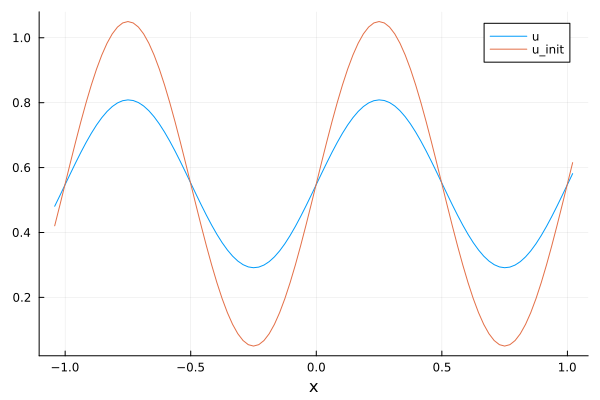

In [30]:
 x, u = solve(fvm, 2.0)
 show_graph(fvm)

N = 100
[Xl, Xr] = [-1.0, 1.0]
dx = 0.020833333333333332, dt = 0.004166666666666667
t = 2.004166666666661, steps = 481


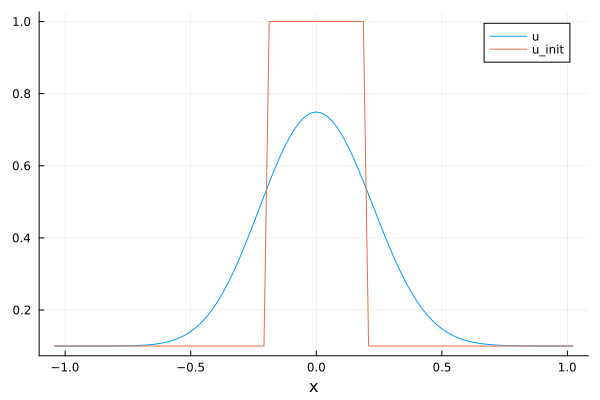

In [32]:
init2(x) = (abs(x) <= 0.2) ? 1.0 : 0.1

fvm2 = FVM(f, df, init2, N=N, Xl=Xl, Xr=Xr)
solve(fvm2, 2.0)
show_graph(fvm2)

N = 100
[Xl, Xr] = [-1.0, 1.0]
dx = 0.020833333333333332, dt = 0.004166666666666667
t = 0.30000000000000016, steps = 72


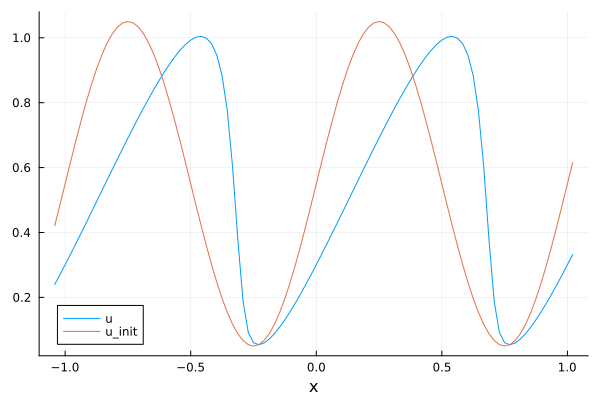

In [34]:
f_burgers(x) = 0.5 * x * x
df_burgers(x) = x

fvm3 = FVM(f_burgers, df_burgers, init, N=N, Xl=Xl, Xr=Xr)
solve(fvm3, 0.3)
show_graph(fvm3)

N = 100
[Xl, Xr] = [-1.0, 1.0]
dx = 0.020833333333333332, dt = 0.004166666666666667
t = 0.30000000000000016, steps = 72


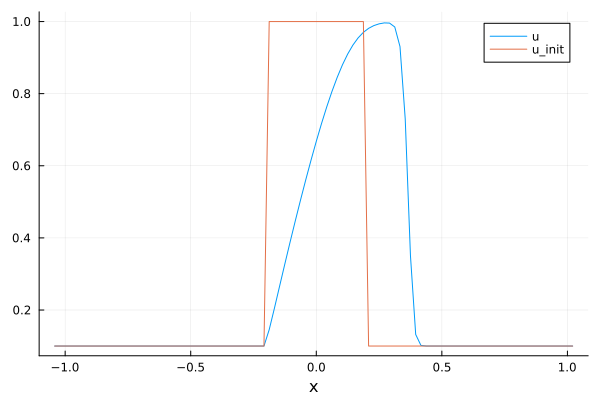

In [35]:
fvm4 = FVM(f_burgers, df_burgers, init2, N=N, Xl=Xl, Xr=Xr)

solve(fvm4, 0.3)
show_graph(fvm4)

N = 100
[Xl, Xr] = [-1.0, 1.0]
dx = 0.020833333333333332, dt = 0.004166666666666667
t = 2.004166666666661, steps = 481


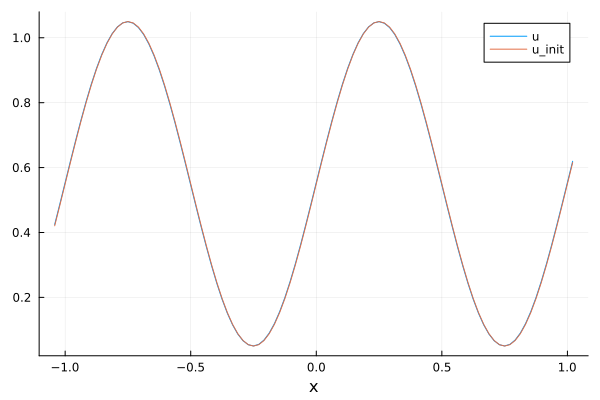

In [36]:
fvm5 = FVM(f, df, init, N=N, Xl=Xl, Xr=Xr)
solve(fvm5, 2.0, solver="Richtmyer")
show_graph(fvm5)

N = 100
[Xl, Xr] = [-1.0, 1.0]
dx = 0.020833333333333332, dt = 0.004166666666666667
t = 2.004166666666661, steps = 481


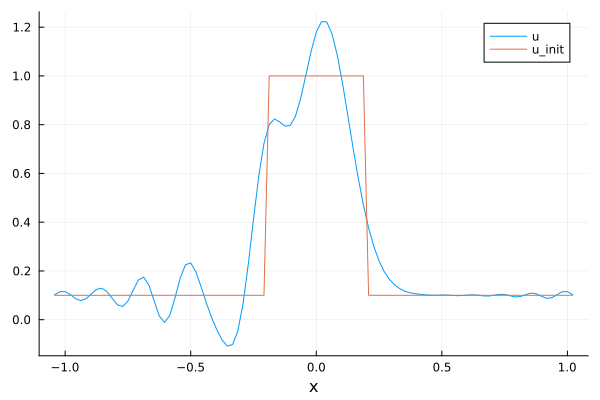

In [37]:
fvm6 = FVM(f, df, init2, N=N, Xl=Xl, Xr=Xr)
solve(fvm6, 2.0, solver="Richtmyer")
show_graph(fvm6)

N = 100
[Xl, Xr] = [-1.0, 1.0]
dx = 0.020833333333333332, dt = 0.004166666666666667
t = 2.004166666666661, steps = 481


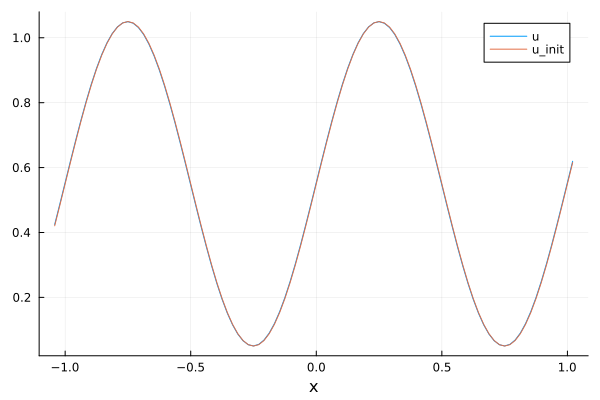

In [38]:
fvm7 = FVM(f, df, init, N=N, Xl=Xl, Xr=Xr)
solve(fvm7, 2.0, rec="Lax_Wendroff")
show_graph(fvm7)

N = 100
[Xl, Xr] = [-1.0, 1.0]
dx = 0.020833333333333332, dt = 0.004166666666666667
t = 2.004166666666661, steps = 481


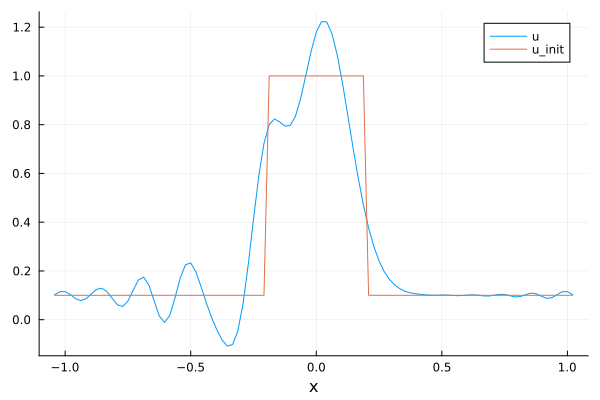

In [39]:
fvm8 = FVM(f, df, init2, N=N, Xl=Xl, Xr=Xr)
solve(fvm8, 2.0, rec="Lax_Wendroff")
show_graph(fvm8)

N = 100
[Xl, Xr] = [-1.0, 1.0]
dx = 0.020833333333333332, dt = 0.004166666666666667
t = 2.004166666666661, steps = 481


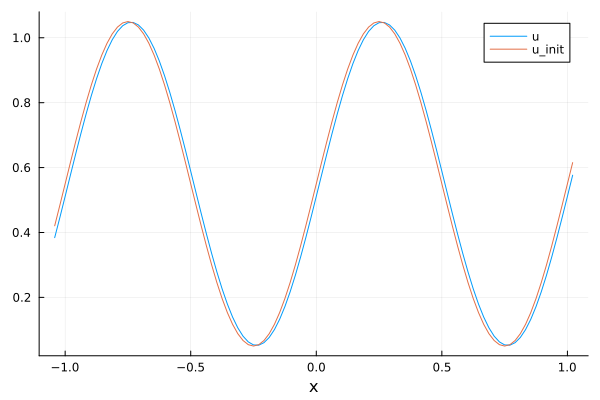

In [40]:
fvm9 = FVM(f, df, init, N=N, Xl=Xl, Xr=Xr)
solve(fvm9, 2.0, rec="Beam_Warming")
show_graph(fvm9)

N = 100
[Xl, Xr] = [-1.0, 1.0]
dx = 0.020833333333333332, dt = 0.004166666666666667
t = 2.004166666666661, steps = 481


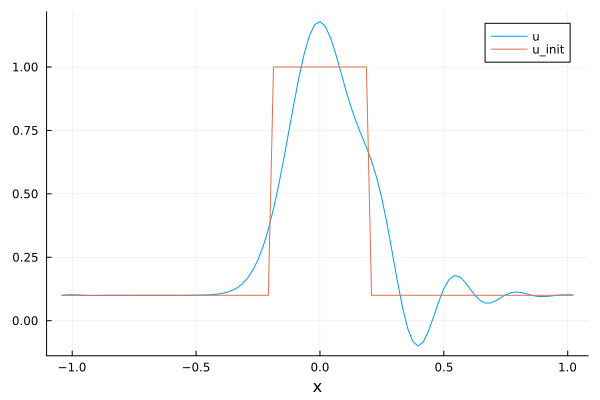

In [41]:
fvm10 = FVM(f, df, init2, N=N, Xl=Xl, Xr=Xr)
solve(fvm10, 2.0, rec="Beam_Warming")
show_graph(fvm10)

N = 100
[Xl, Xr] = [-1.0, 1.0]
dx = 0.020833333333333332, dt = 0.004166666666666667
t = 2.004166666666661, steps = 481


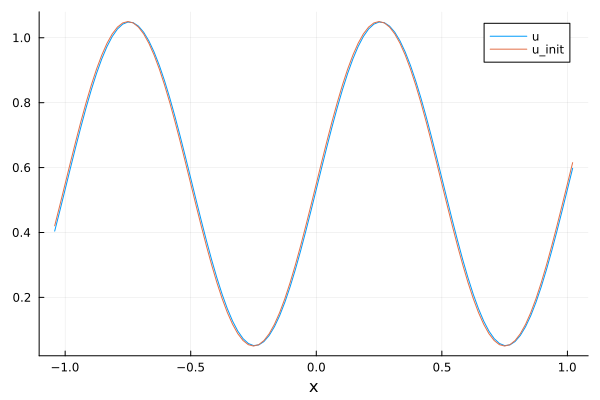

In [42]:
fvm11 = FVM(f, df, init, N=N, Xl=Xl, Xr=Xr)
solve(fvm11, 2.0, rec="Fromm")
show_graph(fvm11)

N = 100
[Xl, Xr] = [-1.0, 1.0]
dx = 0.020833333333333332, dt = 0.004166666666666667
t = 2.004166666666661, steps = 481


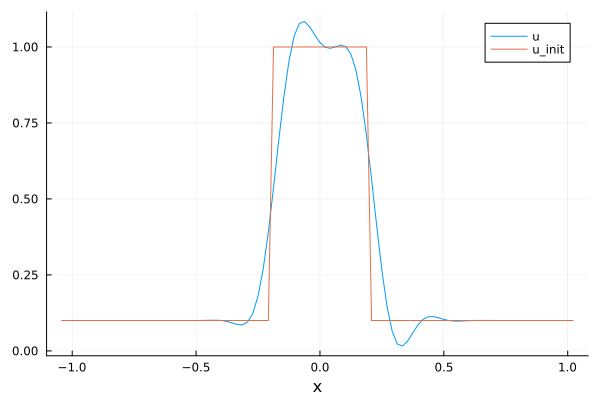

In [43]:
fvm12 = FVM(f, df, init2, N=N, Xl=Xl, Xr=Xr)
solve(fvm12, 2.0, rec="Fromm")
show_graph(fvm12)

N = 100
[Xl, Xr] = [-1.0, 1.0]
dx = 0.020833333333333332, dt = 0.004166666666666667
t = 2.004166666666661, steps = 481


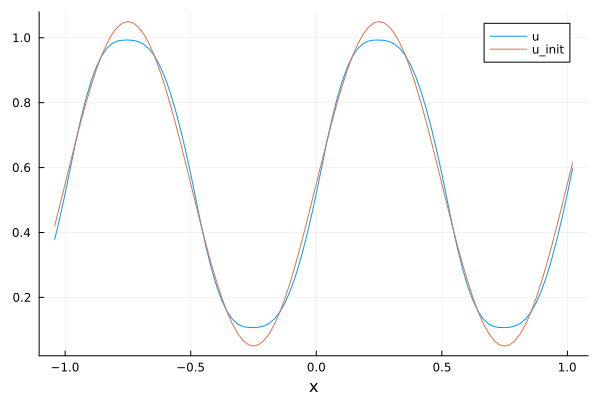

In [44]:
fvm13 = FVM(f, df, init, N=N, Xl=Xl, Xr=Xr)
solve(fvm13, 2.0, rec="minmod")
show_graph(fvm13)

N = 100
[Xl, Xr] = [-1.0, 1.0]
dx = 0.020833333333333332, dt = 0.004166666666666667
t = 2.004166666666661, steps = 481


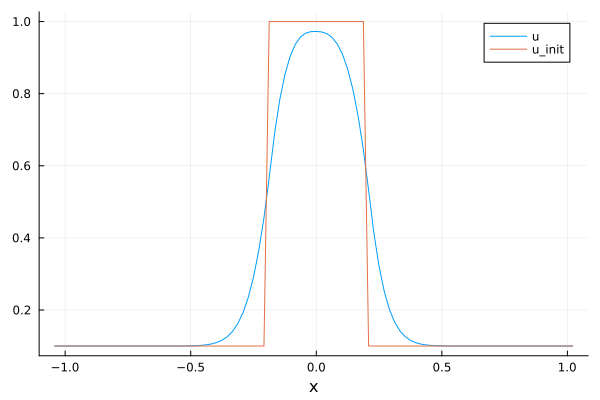

In [45]:
fvm14 = FVM(f, df, init2, N=N, Xl=Xl, Xr=Xr)
solve(fvm14, 2.0, rec="minmod")
show_graph(fvm14)

N = 100
[Xl, Xr] = [-1.0, 1.0]
dx = 0.020833333333333332, dt = 0.004166666666666667
t = 2.004166666666661, steps = 481


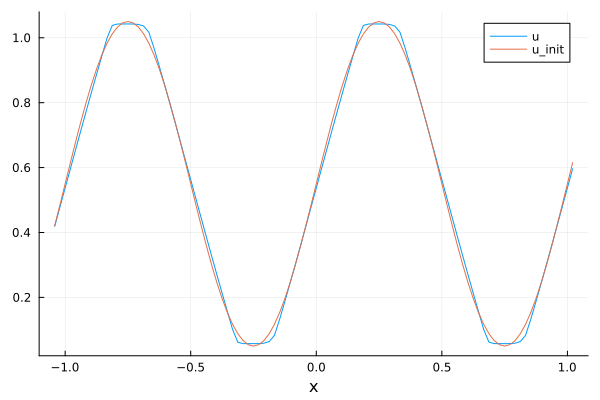

In [46]:
fvm15 = FVM(f, df, init, N=N, Xl=Xl, Xr=Xr)
solve(fvm15, 2.0, rec="superbee")
show_graph(fvm15)

N = 100
[Xl, Xr] = [-1.0, 1.0]
dx = 0.020833333333333332, dt = 0.004166666666666667
t = 2.004166666666661, steps = 481


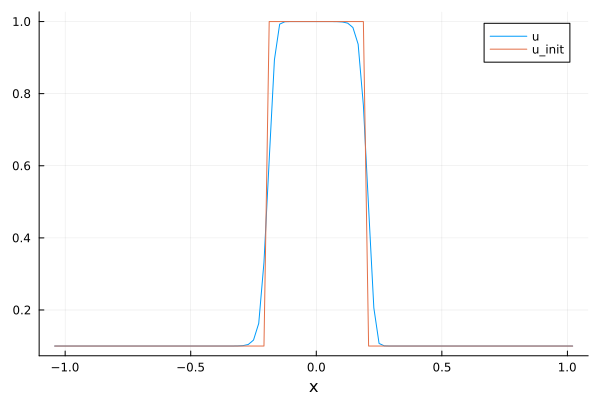

In [47]:
fvm16 = FVM(f, df, init2, N=N, Xl=Xl, Xr=Xr)
solve(fvm16, 2.0, rec="superbee")
show_graph(fvm16)

N = 100
[Xl, Xr] = [-1.0, 1.0]
dx = 0.020833333333333332, dt = 0.004166666666666667
t = 2.004166666666661, steps = 481


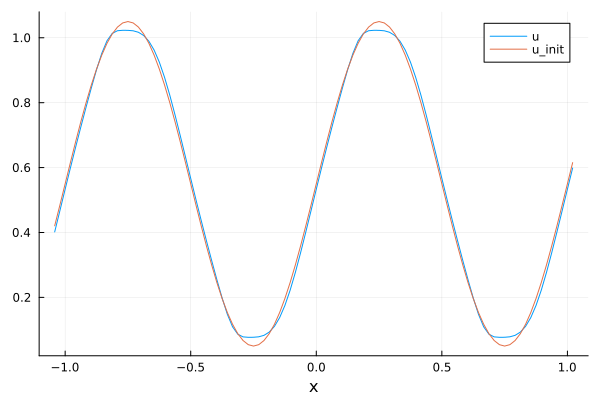

In [48]:
fvm17 = FVM(f, df, init, N=N, Xl=Xl, Xr=Xr)
solve(fvm17, 2.0, rec="van_Leer")
show_graph(fvm17)

N = 100
[Xl, Xr] = [-1.0, 1.0]
dx = 0.020833333333333332, dt = 0.004166666666666667
t = 2.004166666666661, steps = 481


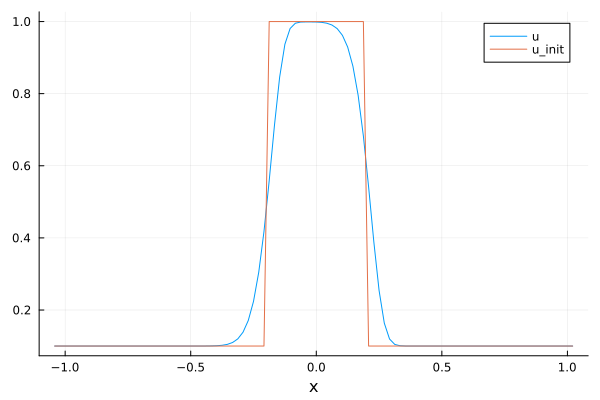

In [49]:
fvm18 = FVM(f, df, init2, N=N, Xl=Xl, Xr=Xr)
solve(fvm18, 2.0, rec="van_Leer")
show_graph(fvm18)

N = 100
[Xl, Xr] = [-1.0, 1.0]
dx = 0.020833333333333332, dt = 0.004166666666666667
t = 2.004166666666661, steps = 481


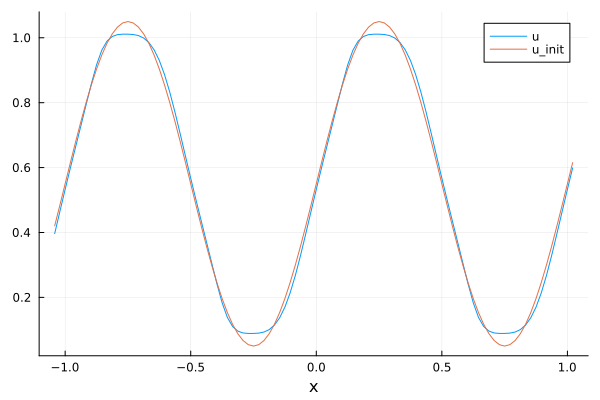

In [50]:
fvm19 = FVM(f, df, init, N=N, Xl=Xl, Xr=Xr)
solve(fvm19, 2.0, rec="van_Albada")
show_graph(fvm19)

N = 100
[Xl, Xr] = [-1.0, 1.0]
dx = 0.020833333333333332, dt = 0.004166666666666667
t = 2.004166666666661, steps = 481


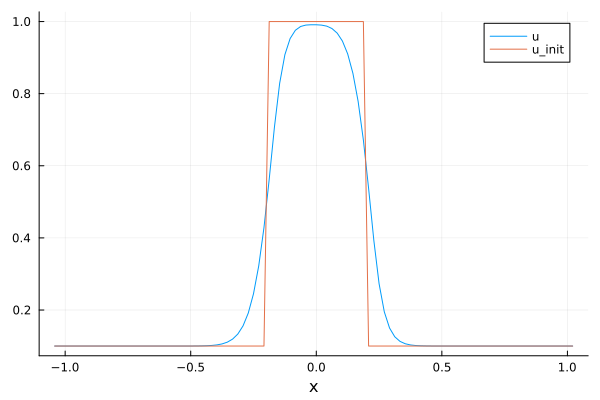

In [51]:
fvm20 = FVM(f, df, init2, N=N, Xl=Xl, Xr=Xr)
solve(fvm20, 2.0, rec="van_Albada")
show_graph(fvm20)

N = 100
[Xl, Xr] = [-1.0, 1.0]
dx = 0.020833333333333332, dt = 0.004166666666666667
t = 0.30000000000000016, steps = 72


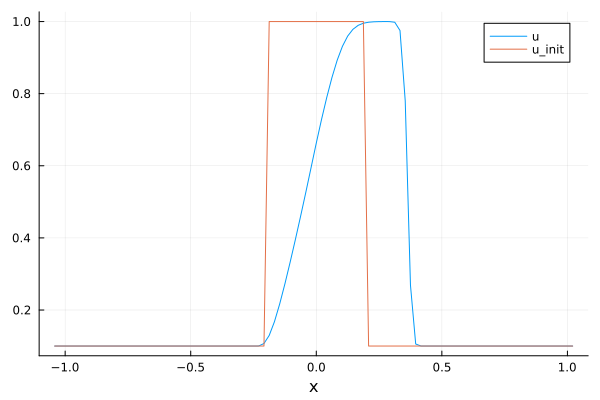

In [52]:
fvm21 = FVM(f_burgers, df_burgers, init2, N=N, Xl=Xl, Xr=Xr)

solve(fvm21, 0.3, rec="minmod", solver="LLF")
show_graph(fvm21)

N = 100
[Xl, Xr] = [-1.0, 1.0]
dx = 0.020833333333333332, dt = 0.004166666666666667
t = 0.30000000000000016, steps = 72


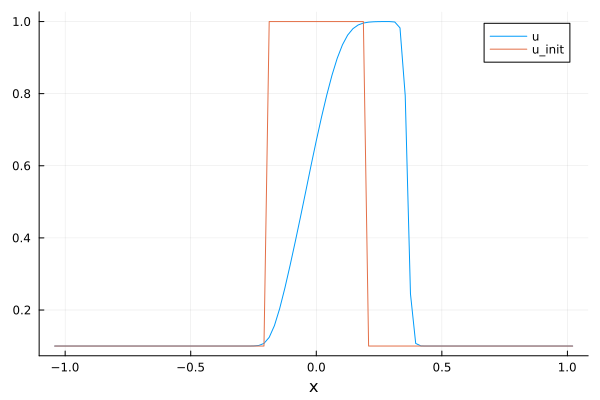

In [53]:
fvm22 = FVM(f_burgers, df_burgers, init2, N=N, Xl=Xl, Xr=Xr)

solve(fvm22, 0.3, rec="minmod", solver="Harten")
show_graph(fvm22)